## 5) ERROR IN RADIUS

Compute error in radius for short-term (< 48h) forecasting;

- dt = R0/V0 is updated at each iteration

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [139]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
    'sav_dat':        False,
    'sav_css':        False,  # If True, save individual cases (for debugging)
}

PTHS = {
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/05_ERROR_IN_RADIUS/'
}

### 1) Functions and model

In [3]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

In [4]:
### RESOLUTION
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def N(r, M):
    '''Rotational stability frequency'''
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    return np.sqrt(N2)

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                     # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})               # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})               # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

##############################
### SMOOTHING WITH HOLLAND ###
##############################

def get_valid_radii(r, V):
    '''Given the wind profile V, returns the largest radius (and asociated V) on which the profile can be fitted. 
    Indeed, sometimes V isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(r)
    
    ### Lower bound
    # We change it if V[0] = nan
    if np.isnan(V[0]):
        first_valid_index = np.min(np.where(np.isfinite(V)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.count_nonzero(np.isnan(V[first_valid_index:])) > 0:
        last_valid_index  = np.min(np.where(np.isnan(V[first_valid_index:]))[0])# returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
        
    # Define r and spdm
    r = r[first_valid_index:last_valid_index]
    V = V[first_valid_index:last_valid_index]
    
    return r, V

def holland_profile2(r, fcor, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    rho    = 1.15

    r      = r.astype(float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt(((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_holland2(r, spdm, fcor, B, Vmin, Rmax, Vmax):
    '''Fit the Holland profile given initial values of lat, pn, pc, Vmin, Rmax and Vmax.
    Returns the optimal parameters found with curve_fit()'''
    # Define the bounds
    BOUNDS = {
        'B':    [1, 3],
        'Vmin': [0, 50],
        'Rmax': [5 * 1000, 500 * 1000],
        'Vmax': [10, 100]
        } 
    # Don't take std into account
    sigma = None
    # Fit
    popt, pcov = curve_fit(
        lambda r, B, Vmin, Rmax, Vmax: holland_profile2(r, fcor, B, Vmin, Rmax, Vmax), 
        r, 
        spdm, 
        p0=[B, Vmin, Rmax, Vmax], 
        bounds=(tuple([BOUNDS[e][0] for e in BOUNDS.keys()]), # NB: lat is fixed
                tuple([BOUNDS[e][1] for e in BOUNDS.keys()])
               ) 
    ) 
    return popt, pcov

def smooth_with_holland(r, V, fcor):
    # Initialize Holland
    B_guess = 1.8
    vmx     = np.nanmax(V)
    rmx     = r[np.nanargmax(V)]
    vmn     = np.nanmin(V)
    
    # Get valid domain
    r_crop, V_crop = get_valid_radii(r, V)
    
    # Fit Holland
    popt, _ = fit_holland2(r_crop, V_crop, fcor, B_guess, vmn, rmx, vmx)
    V_fit   = holland_profile2(r, fcor, popt[0], popt[1], popt[2], popt[3])
    
    return V_fit

################
### FRICTION ###
################

def compute_lbda(r, V, fcor, R_plus, V_plus, gamma=1/40, Cd_plus=2e-3, K=10):
    M_abs = r * V + 0.5 * fcor * (r ** 2)
    M_rel = r * V
        
    left  = gamma * float(Cd_plus * (V_plus ** 2) * R_plus) / (fcor * M_abs)
    right = np.sqrt(N(r, M_abs) / (2 * K))
    lbda  = left * right
    
    return np.array(lbda)

###################
### CHARAC TIME ###
###################

def compute_tau_recirculation(r, V, fcor):
    vmx = np.nanmax(V)
    rmx = r[np.nanargmax(V)]
    r0  = np.sqrt(2 * vmx / (fcor * rmx)) * rmx
    v0  = V[r >= r0][0]
    return (r0 / v0) / 3600

#############
### MODEL ###
#############

# def MODEL(r, V_ini, fcor_ini, fcor_fin, HPRMS):
#     '''Former version, in which the final time is not exactly matched by the model.'''
#     # Initialize
#     vk10s = []
#     dts   = []
    
#     # Initialization (a parametric profile, e.g Holland)
#     V       = V_ini
#     delta_m = 0
#     tau2    = 999
    
#     # Iterations
#     while delta_m < HPRMS['delta_h'] + (tau2 / 2.):
#         # Append
#         vk10s.append(V)
#         dts.append(delta_m)
        
#         # Compute Coriolis
#         fcor           = fcor_ini + (delta_m / HPRMS['delta_h']) * (fcor_fin - fcor_ini)
        
#         # Compute dt
#         tau1           = (1 / fcor) / 3600
#         tau2           = compute_tau_recirculation(r, V, fcor) # Compute R0/V0
#         # tau2           = compute_tau_recirculation(r, V, fcor) / 1.3 # Compute R0/V0
#         delta_m       += tau2
#         dt             = tau2 / tau1
#         # print(dt)
        
#         # Characteristic scales
#         R_plus, V_plus = compute_RV_plus(r, V, fcor, PRMS['n'])
#         L              = R_plus
        
#         # Compute lambda USING a Holland parametric profile (else noise appears during computation and is amplified in the iterations)
#         V_hol = smooth_with_holland(r, V, fcor)
#         lbda  = compute_lbda(r, V_hol, fcor, R_plus, V_plus, HPRMS['gamma'], HPRMS['Cd_plus'], HPRMS['K']) # non-dimensional
        
#         # Normalize
#         V_nrm = xr.DataArray(
#             data=V / (fcor * L),
#             coords={'rad': r / L}
#         )

#         # Apply KK10
#         V = v_k10(V_nrm, t=dt, lbda=lbda) * fcor * L # dimensional
        
#     return vk10s, dts   

def MODEL(r, V_ini, fcor_ini, fcor_fin, HPRMS):
    '''Updated version, in which the exact final time is matched.'''
    # Initialize
    vk10s = []
    dts   = []
    
    # Initialization (a parametric profile, e.g Holland)
    V       = V_ini
    delta_m = 0
    tau2    = 999
    
    # Iterations
    while delta_m < HPRMS['delta_h']:
        # Append
        vk10s.append(V)
        dts.append(delta_m)
        
        # Compute Coriolis
        fcor           = fcor_ini + (delta_m / HPRMS['delta_h']) * (fcor_fin - fcor_ini)
        
        # Compute dt
        tau1           = (1 / fcor) / 3600
        tau2           = compute_tau_recirculation(r, V, fcor) # Compute R0/V0
        # tau2           = compute_tau_recirculation(r, V, fcor) / 1.3 # Compute R0/V0
        delta_m       += tau2
        dt             = tau2 / tau1
        # print(dt)
        
        # Characteristic scales
        R_plus, V_plus = compute_RV_plus(r, V, fcor, PRMS['n'])
        L              = R_plus
        
        # Compute lambda USING a Holland parametric profile (else noise appears during computation and is amplified in the iterations)
        V_hol = smooth_with_holland(r, V, fcor)
        lbda  = compute_lbda(r, V_hol, fcor, R_plus, V_plus, HPRMS['gamma'], HPRMS['Cd_plus'], HPRMS['K']) # non-dimensional
        
        # Normalize
        V_nrm = xr.DataArray(
            data=V / (fcor * L),
            coords={'rad': r / L}
        )

        # Apply KK10
        V = v_k10(V_nrm, t=dt, lbda=lbda) * fcor * L # dimensional
    
    # Last iteration to exactly match the final time
    # NB: recall that fcor, tau1 and tau2 have already been defined in the last iteration of the while loop
    dt = (HPRMS['delta_h'] - (delta_m - tau2)) / tau1
    # print(dt)
    V  = v_k10(V_nrm, t=dt, lbda=lbda) * fcor * L # dimensional
    vk10s.append(V)
    dts.append(HPRMS['delta_h'])
        
    return vk10s, dts

def interpolate_two_profiles(r, V_ini, fcor_ini, fcor_fin, delta_h, K=20):
    # Hyperparameters
    HPRMS = {
        'delta_h': delta_h,
        'gamma':   1/40,
        'K':       K,              # m^2/s, diffusivity coefficient
        'Cd_plus': 2.5e-3,         # [], drag coefficient, maximal at R+ (so shouldn't be tuned)
    }
    
    # Run model
    vk10s = MODEL(r, V_ini, fcor_ini, fcor_fin, HPRMS)
    
    return vk10s

### OPTIMIZE K ON FINAL VMAX
def binary_search(r, V_ini, fcor_ini, vmx_fin, fcor_fin, delta_h, K_low=0, K_hgh=100):
    err    = 999
    last_K = 999
    
    # Accepted error on Vmax is 1 m/s
    while abs(err) > 1:
        K_mid = (K_hgh + K_low) // 2
        # print(K_mid)
        
        # Raise Error if K_mid = 0
        if K_mid == 0:
            raise KfitError

        # Compute model and error
        vk10s, _ = interpolate_two_profiles(r, V_ini, fcor_ini, fcor_fin, delta_h, K_mid)
        err      = np.nanmax(vk10s[-1]) - np.nanmax(vmx_fin)

        if err > 0:
            K_hgh = K_mid - 1
        else:
            K_low = K_mid + 1
        
        if K_mid == last_K:
            err = 0
        last_K = K_mid
            
    return vk10s, K_mid

### K fit exception
class KfitError(Exception):
    "Raised when Kfit = 0 in the binary search"
    pass

### 2) SAR data

In [5]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 30, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

# Select IDs where there are at least 2 SAR images
ids, cts  = np.unique(dsg.storm_id, return_counts=True)
valid_ids = ids[cts > 1]
# valid_cts = cts[cts > 1]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 137
SAR Mean Rmax = 30 km
SAR Mean R64  = 57 km


In [6]:
# valid_ids = ['wp242019']

In [7]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

# Parameters
time_thresh  = 48

# Initialization
IDXS_INI     = []
IDXS_FIN     = []
TC_IDS       = []
DELTA_HS     = []
KS           = []
RMSES        = []
RMSES_PRS    = []
VMXS_INI     = []
VMXS_FIN     = []
RPLS_INI     = []
RPLS_FIN     = []
RPLS_MOD     = []
REL_ERRS     = []
REL_ERRS_PRS = []
r_ref        = np.linspace(0, 10, 1001)

for tc_id in tqdm(valid_ids):
    print(tc_id)
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
            V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
            Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
            Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if delta_h <= time_thresh:
                # print('ok')
                try:
                    vk10s, Kfit = binary_search(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), np.nanmax(V_fin), float(abs(coriolis(ds_fin.lat_center))), delta_h, K_low=0, K_hgh=100)
                    # Compute RMSE
                    rmse        = np.sqrt(np.nanmean((vk10s[-1] - Vh_fin) ** 2))
                    rmse_prs    = np.sqrt(np.nanmean((Vh_ini - Vh_fin) ** 2))    # Persistence
                    # print('Dt = {:.1f}h, Vmax = {:.1f} m/s, Kfit = {}'.format(delta_h, np.nanmax(Vh_ini), Kfit))
                    
                    ### Compute relative errors and put that on an r_star-grid
                    # Option 1: Compute relative to Holland final profile
                    rel_err          = (vk10s[-1] - Vh_fin) / Vh_fin
                    rmx              = rs[np.nanargmax(Vh_fin)]
                    r_star           = rs / rmx
                    rel_err_star     = np.interp(r_ref, r_star, rel_err)
                    rel_err_prs      = (Vh_ini - Vh_fin) / Vh_fin                # Persistence
                    rel_err_prs_star = np.interp(r_ref, r_star, rel_err_prs)     # Persistence
                    # # Option 2: Compute relative to SAR final profile
                    # rel_err          = (vk10s[-1] - V_fin) / V_fin
                    # rmx              = rs[np.nanargmax(V_fin)]
                    # r_star           = rs / rmx
                    # rel_err_star     = np.interp(r_ref, r_star, rel_err)
                    # rel_err_prs      = (Vh_ini - V_fin) / V_fin                  # Persistence
                    # rel_err_prs_star = np.interp(r_ref, r_star, rel_err_prs)     # Persistence
                    
                    # Compute R+ metrics
                    Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini,    float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                    Rp_fin, Vp_fin   = compute_RV_plus(rs, Vh_fin,    float(abs(coriolis(ds_fin.lat_center))), PRMS['n'])
                    Rp_mod, Vp_mod   = compute_RV_plus(rs, vk10s[-1], float(abs(coriolis(ds_fin.lat_center))), PRMS['n'])
                    
                    # Appends
                    IDXS_INI.append(idx_ini), IDXS_FIN.append(idx_fin), TC_IDS.append(tc_id), DELTA_HS.append(delta_h), KS.append(Kfit), RMSES.append(rmse)
                    RMSES_PRS.append(rmse_prs), VMXS_INI.append(np.nanmax(V_ini)), VMXS_FIN.append(np.nanmax(V_fin))
                    REL_ERRS.append(rel_err_star), REL_ERRS_PRS.append(rel_err_prs_star), RPLS_INI.append(Rp_ini), RPLS_FIN.append(Rp_fin), RPLS_MOD.append(Rp_mod)
                    
                    # Plot
                    if PRMS['sav_css']:
                        plt.title('{}, idx_ini = {}, idx_fin = {} \n delta_h = {:.1f} hrs, K = {}'.format(tc_id, idx_ini, idx_fin, delta_h, Kfit), weight='bold')
                        # SAR profiles
                        plt.plot(rs / 1000, V_ini,  c='k',         linewidth=3,                     label='SAR Initial')
                        plt.plot(rs / 1000, V_fin,  c='orangered', linewidth=3,                     label='SAR Final')
                        # Holland profiles
                        plt.plot(rs / 1000, Vh_ini, c='k',         linewidth=1, linestyle='dotted', label='Holland Initial')
                        plt.plot(rs / 1000, Vh_fin, c='orangered', linewidth=1, linestyle='dotted', label='Holland Final')
                        # Model
                        l    = len(vk10s)
                        clrs = cm(np.linspace(0, 1, l))
                        for k in range(1, l):
                            plt.plot(rs / 1000, vk10s[k], linestyle='dashed', c=clrs[k], label='MODEL, step {}'.format(k))
                        # Legend
                        plt.xlabel('Radius (km)');plt.ylabel('Wind speed (m/s)')
                        plt.xlim(0, 500);plt.legend(frameon=False)
                        plt.savefig(PTHS['sav_dir'] + 'cases/{}_ini{}_fin{}'.format(tc_id, idx_ini, idx_fin));plt.clf()
                    
                # except InertiallyUnstableError:
                #     print('Inertially unstable wind profile in function N()')
                except KfitError:
                    print('K fitting procedure led to K = 0')
                    
# Concatenate and save
dsf = xr.Dataset(
    data_vars={
        'tc_id':       ('pair', np.array(TC_IDS).astype(str)),
        'idx_ini':     ('pair', IDXS_INI),
        'idx_fin':     ('pair', IDXS_FIN),
        'delta_h':     ('pair', DELTA_HS),
        'K':           ('pair', KS),
        'rmse':        ('pair', RMSES),
        'rmse_prs':    ('pair', RMSES_PRS),
        'vmx_ini':     ('pair', VMXS_INI),
        'vmx_fin':     ('pair', VMXS_FIN),
        'Rp_ini':      ('pair', RPLS_INI),
        'Rp_fin':      ('pair', RPLS_FIN),
        'Rp_mod':      ('pair', RPLS_MOD),
        'rel_err':     (('pair', 'r*'), REL_ERRS),
        'rel_err_prs': (('pair', 'r*'), REL_ERRS_PRS),
    }
)
if PRMS['sav_dat']:
    dsf.to_netcdf(PTHS['sav_dir'] + 'dsf.nc')

  0%|          | 0/31 [00:00<?, ?it/s]

al052019
al122021
al182021
ep062021
ep082020
ep092014
ep102018
K fitting procedure led to K = 0
ep122015
ep132016
ep142018
ep152018
ep162018
ep172018
ep182020
ep202018
ep212018
io022019
sh072018
sh172019
K fitting procedure led to K = 0
sh192021
sh222019
K fitting procedure led to K = 0
K fitting procedure led to K = 0
K fitting procedure led to K = 0
sh242021
wp022021
wp072015
wp122016
K fitting procedure led to K = 0
wp152018
wp202021
wp222020
wp242019
K fitting procedure led to K = 0
wp252018
wp312018


In [8]:
# ### LOAD DATA (IF AVAILABLE)
# dsf = xr.open_dataset(PTHS['sav_dir'] + 'dsf.nc')

In [114]:
### Filter on time
# keep = (dsf.delta_h <= 24) & (dsf.vmx_fin - dsf.vmx_ini > 0)
# keep = (dsf.delta_h <= 24) & (dsf.K > 50)
keep = (dsf.delta_h <= 24)
d    = dsf.where(keep, drop=True)

In [115]:
# plt.hist(d.rmse / d.rmse_prs, bins=100)

(array([5., 0., 3., 1., 5., 2., 3., 3., 0., 1.]),
 array([-11550.,  -9051.,  -6552.,  -4053.,  -1554.,    945.,   3444.,
          5943.,   8442.,  10941.,  13440.]),
 <BarContainer object of 10 artists>)

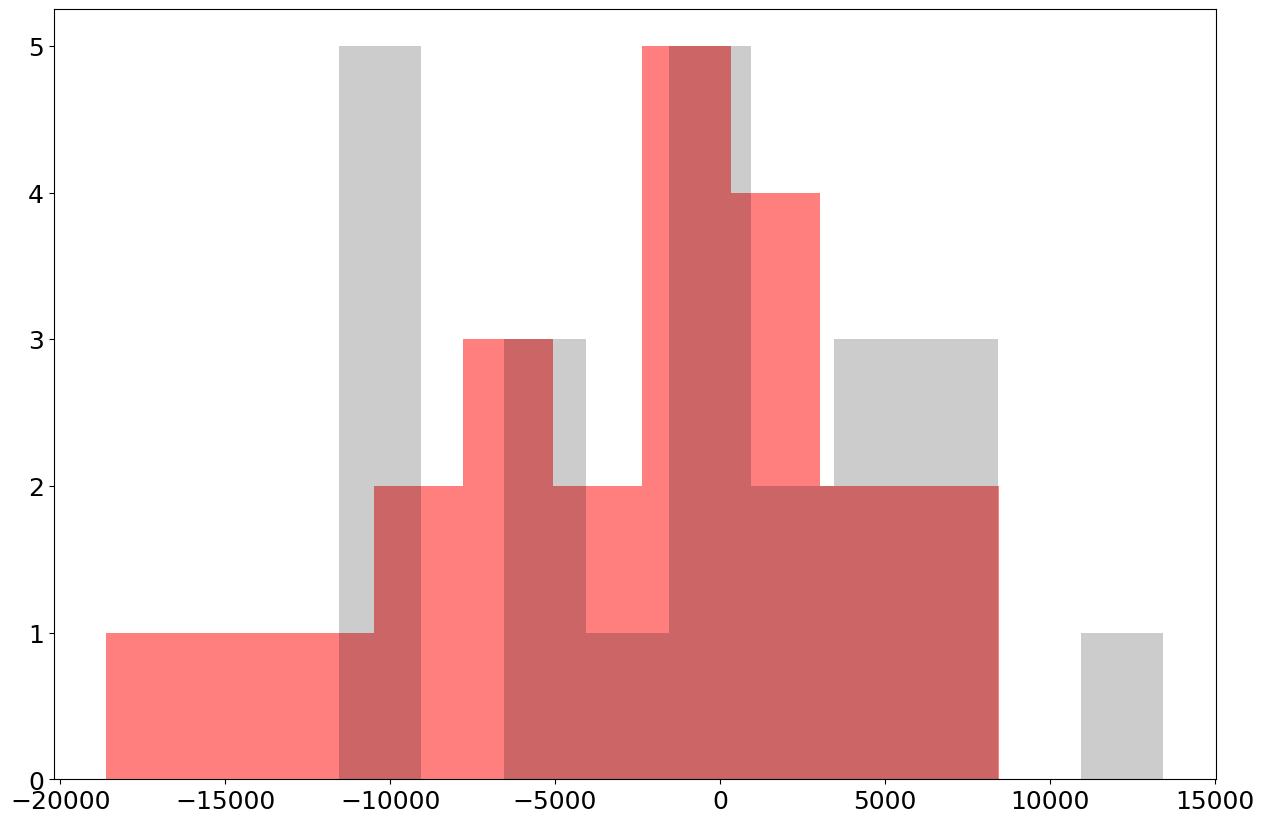

In [116]:
plt.hist(d.Rp_mod - d.Rp_fin, color='r', alpha=0.5)
plt.hist(d.Rp_ini - d.Rp_fin, alpha=0.2, color='k')

In [137]:
# plt.scatter(d.Rp_fin, d.Rp_mod, c='r')
# plt.scatter(d.Rp_fin, d.Rp_ini, c='k')
# plt.plot([30000, 90000], [30000, 90000])

In [118]:
# d.where(d.Rp_mod - d.Rp_fin < -15000, drop=True)

In [119]:
abs(d.Rp_mod - d.Rp_fin).mean()

<xarray.DataArray ()>
array(5523.91304348)

In [120]:
abs(d.Rp_ini - d.Rp_fin).mean()

<xarray.DataArray ()>
array(5501.73913043)

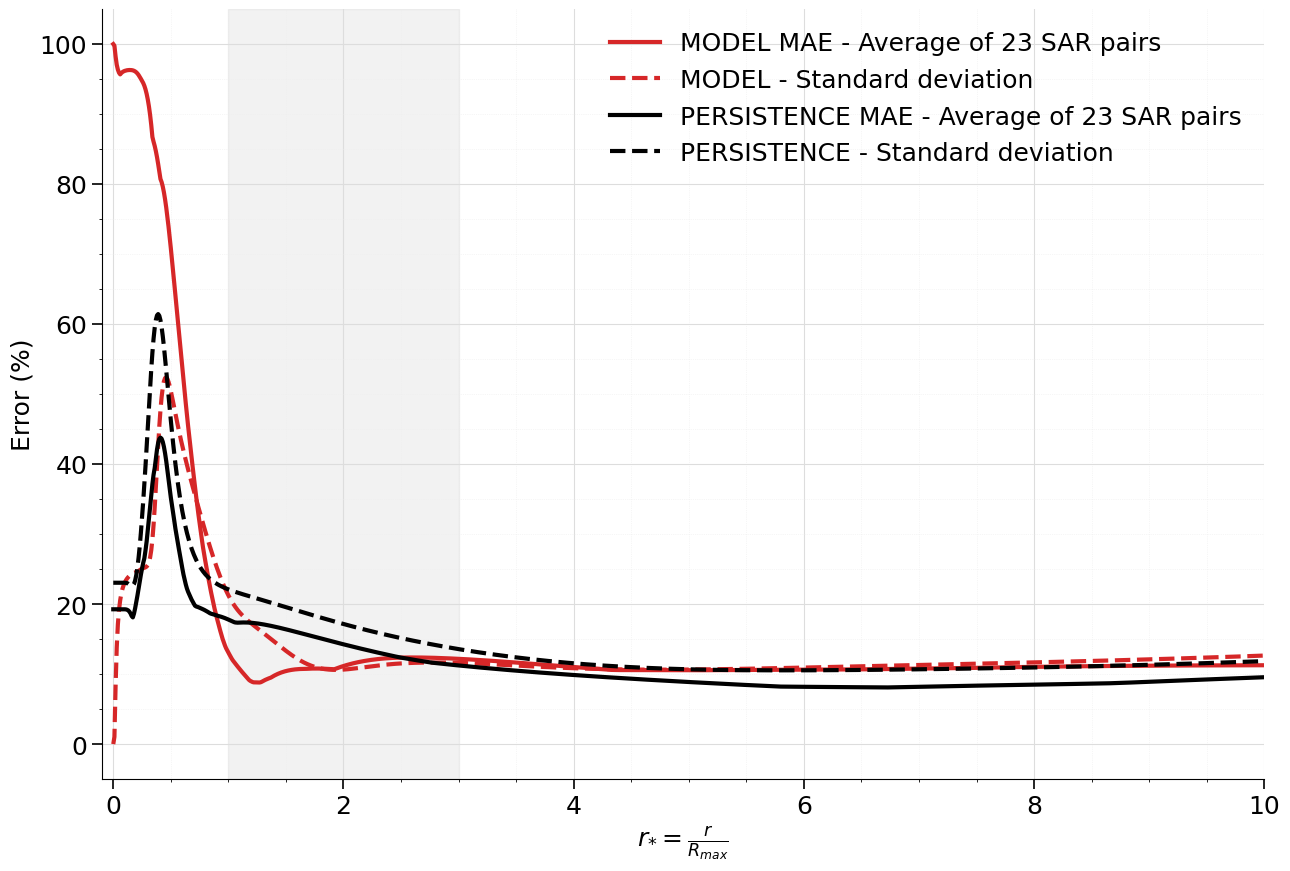

In [138]:
### SYNTHETIC PLOT
c_mod = 'tab:red'
c_prs = 'k'

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Model
# ax.plot(r_ref, d.mean(dim='pair').rel_err * 100,                                   linewidth=3, c=c_mod, label='MODEL - Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, (abs(d.rel_err) * 100).mean(dim='pair'),                            linewidth=3, c=c_mod, label='MODEL MAE - Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.std(dim='pair').rel_err * 100,                                    linewidth=3, c=c_mod, linestyle='dashed', label='MODEL - Standard deviation')
# ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 + d.std(dim='pair').rel_err * 100, linewidth=3, c=c_mod, linestyle='dashed', label='MODEL - Standard deviation')
# ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 - d.std(dim='pair').rel_err * 100, linewidth=3, c=c_mod, linestyle='dashed')

# Persistence
# ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100,                                       linewidth=3, c=c_prs, label='PERSISTENCE - Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, (abs(d.rel_err_prs) * 100).mean(dim='pair'),                                linewidth=3, c=c_prs, label='PERSISTENCE MAE - Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.std(dim='pair').rel_err_prs * 100,                                        linewidth=3, c=c_prs, linestyle='dashed', label='PERSISTENCE - Standard deviation')
# ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 + d.std(dim='pair').rel_err_prs * 100, linewidth=3, c=c_prs, linestyle='dashed', label='PERSISTENCE - Standard deviation')
# ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 - d.std(dim='pair').rel_err_prs * 100, linewidth=3, c=c_prs, linestyle='dashed')
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5);ax.minorticks_on()
ax.set_xlim(-0.1, 10)
# ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Error (%)')
ax.legend(frameon=False, loc='upper right')

# # Colorbar
# norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
# sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
# cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
# cbar.formatter.set_useMathText(True)
# cbar.set_label(r'$\Delta t$ (hrs)', rotation=90)
# cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

In [126]:
# d.where(d.rel_err * 100 > 80, drop=True)

In [127]:
# d1 = dsf.where(dsf.tc_id == 'wp242019', drop=True).isel(pair=1)

# plt.plot(r_ref, d1.rel_err * 100,     label='model', c='r')
# plt.plot(r_ref, d1.rel_err_prs * 100, label='persistence', c='k')
# plt.axvline(1);plt.axvline(3)
# plt.xlabel('r*');plt.ylabel('Relative error')
# plt.legend();plt.grid()

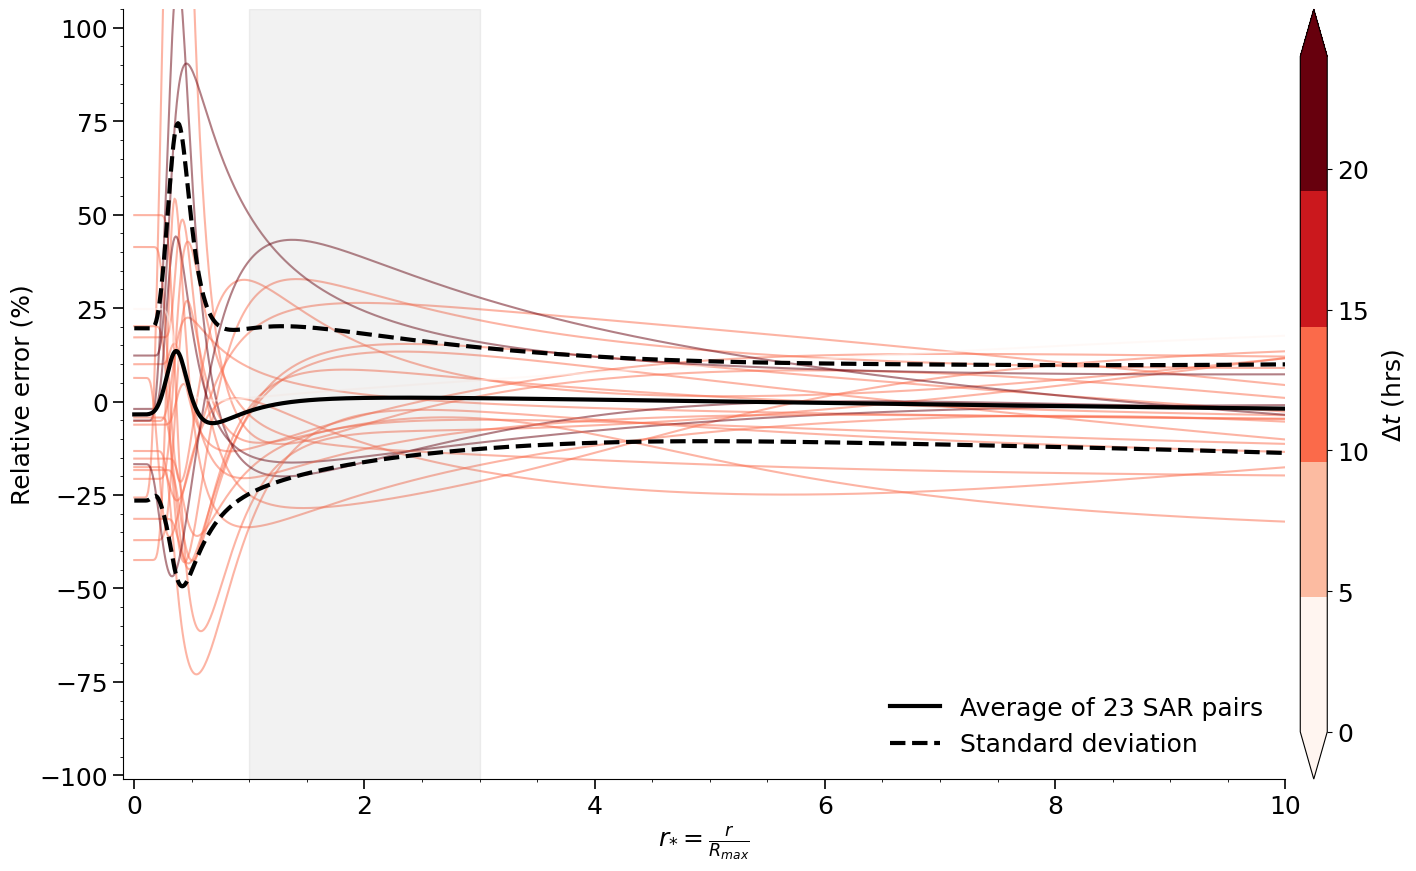

In [128]:
### STARTING WITH PERSISTENCE
# Colors
c_min = 0
c_max = 24
d['delta_vmx_color'] = (d.delta_h - c_min) / (c_max - c_min)
cmap  = mpl.cm.get_cmap('Reds', 5)

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 + d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 - d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err_prs * 100, c=cmap(d.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$\Delta t$ (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

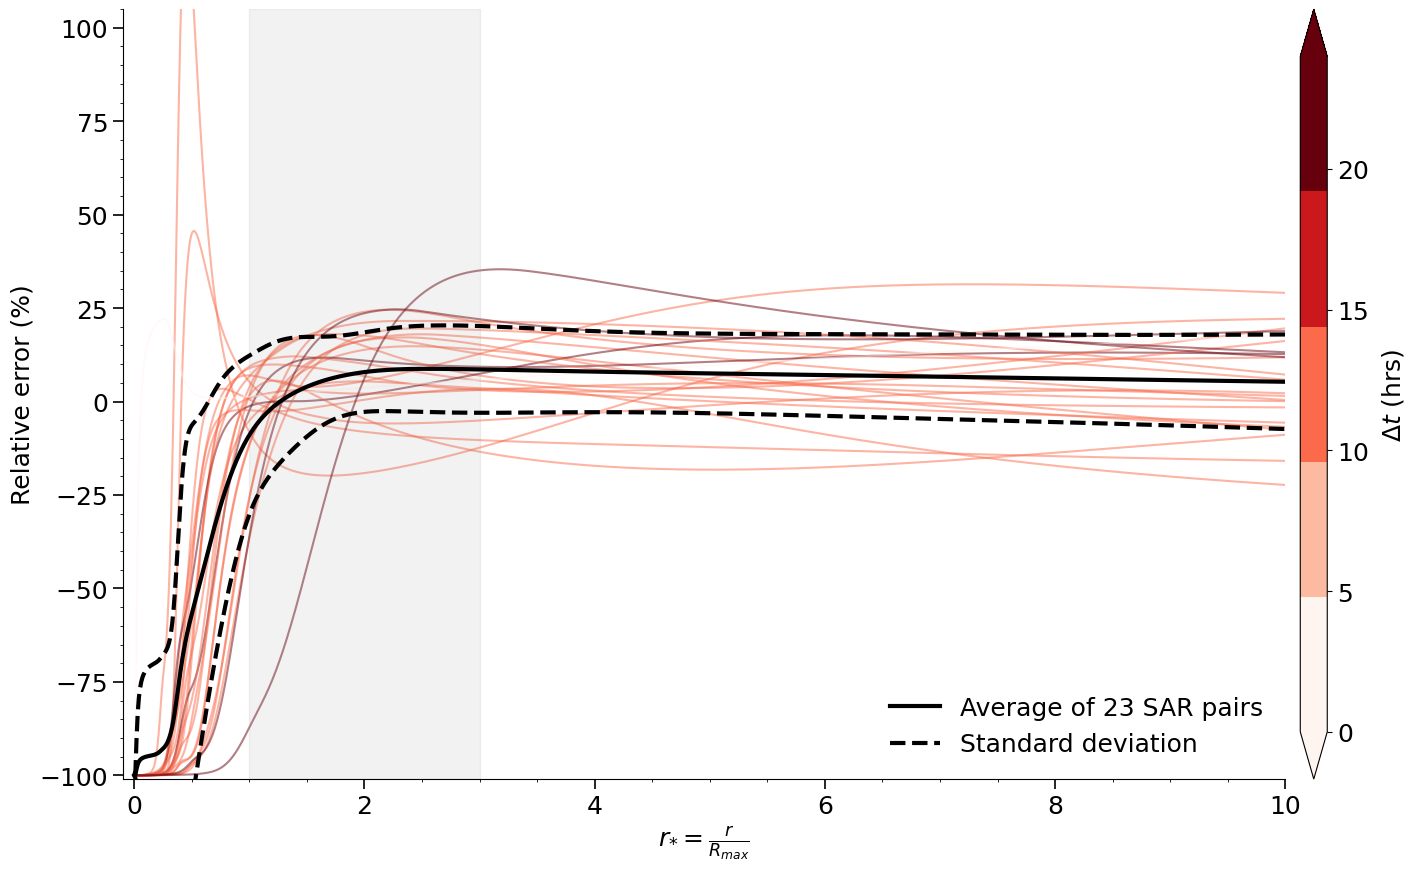

In [129]:
# Colors
c_min = 0
c_max = 24
d['delta_vmx_color'] = (d.delta_h - c_min) / (c_max - c_min)
cmap  = mpl.cm.get_cmap('Reds', 5)

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 + d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 - d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err * 100, c=cmap(d.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$\Delta t$ (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

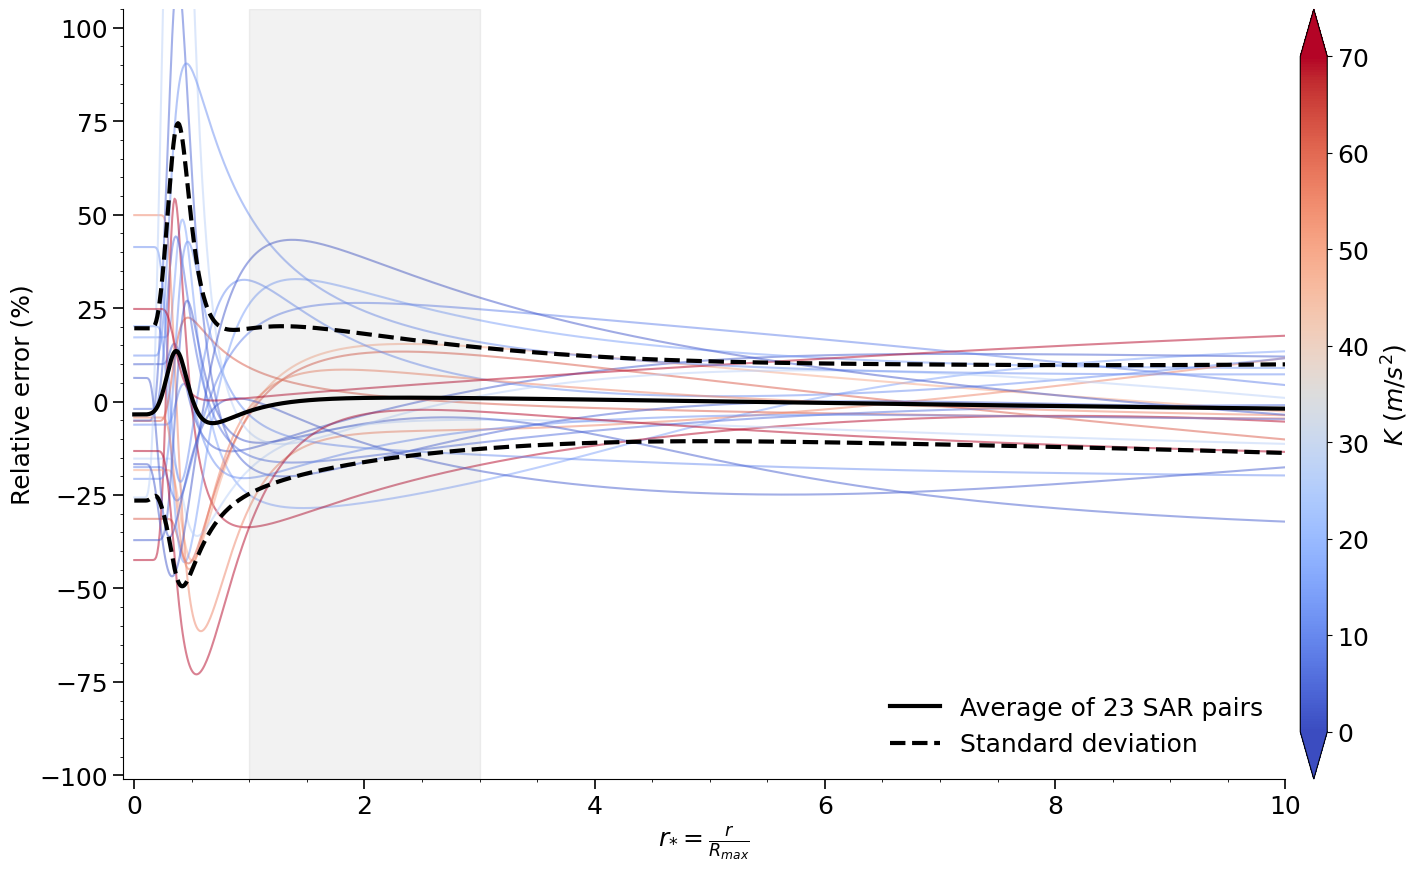

In [130]:
### PERSISTENCE
# Colors
c_min = 0
c_max = 70
d['delta_vmx_color'] = (d.K - c_min) / (c_max - c_min)
cmap  = mpl.cm.get_cmap('coolwarm')

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 + d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 - d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err_prs * 100, c=cmap(d.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$K$ ($m/s^2$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

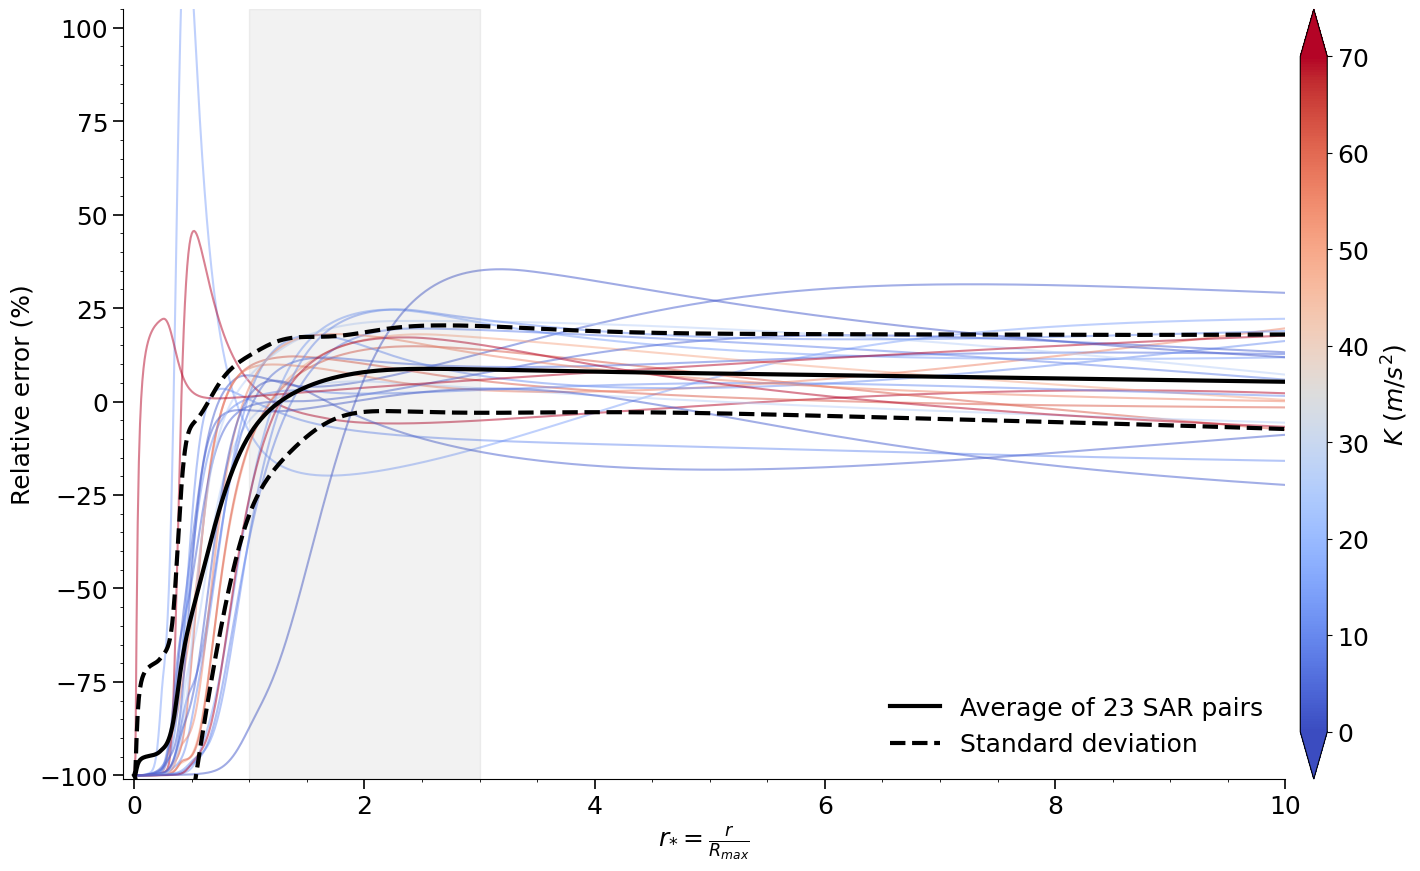

In [131]:
# Colors
c_min = 0
c_max = 70
d['delta_vmx_color'] = (d.K - c_min) / (c_max - c_min)
cmap  = mpl.cm.get_cmap('coolwarm')

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 + d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 - d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err * 100, c=cmap(d.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$K$ ($m/s^2$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

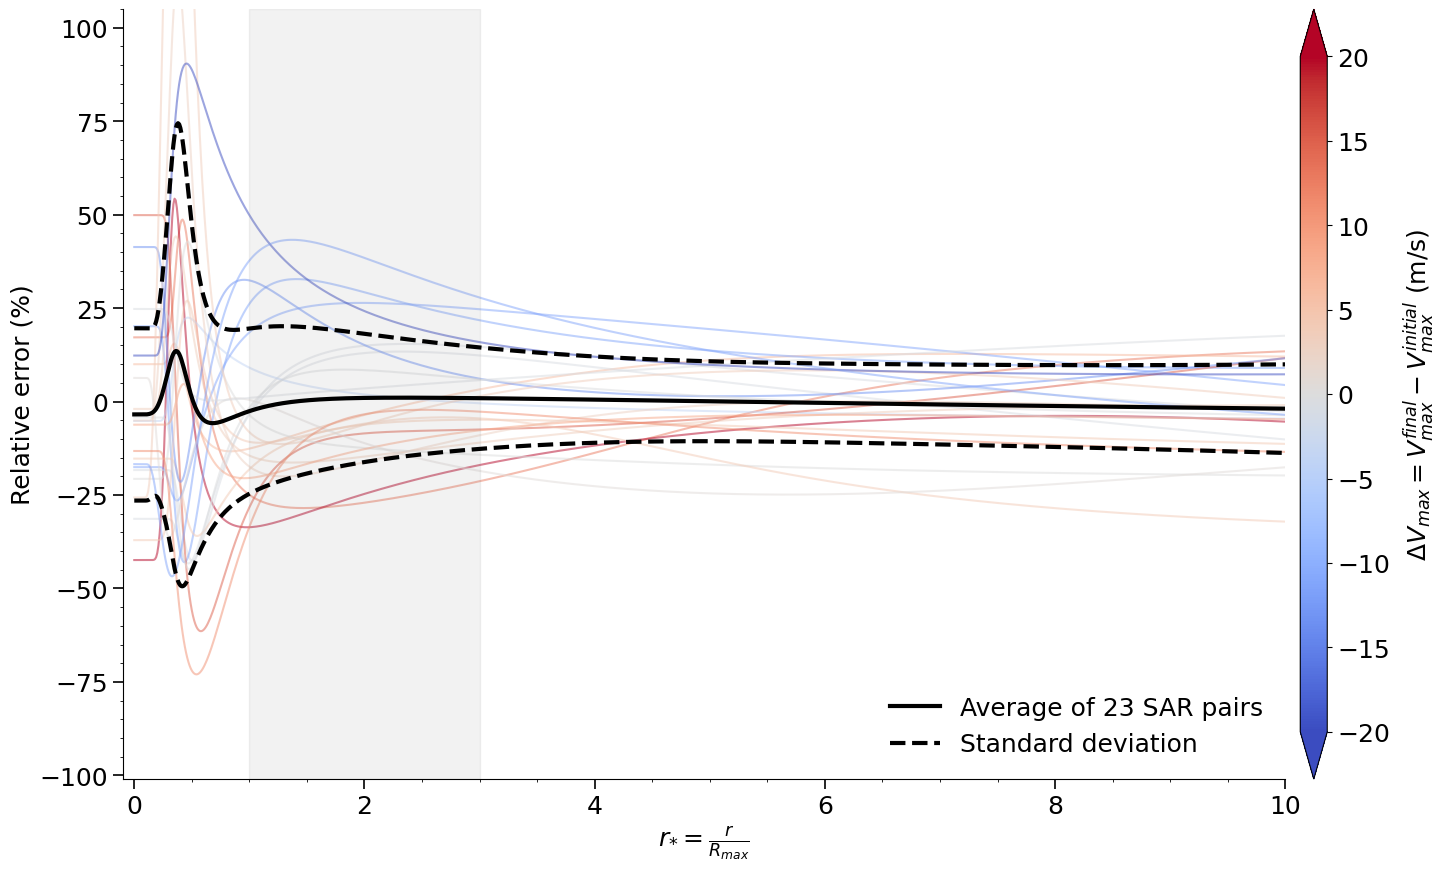

In [132]:
### PERSISTENCE

# Colors
c_min = -20
c_max = 20
delta_vmx = d.vmx_fin - d.vmx_ini
d['delta_vmx_color'] = (delta_vmx - c_min) / (c_max - c_min)
cmap  = mpl.cm.get_cmap('coolwarm')

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 + d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 - d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err_prs * 100, c=cmap(d.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$\Delta V_{max} = V_{max}^{final} - V_{max}^{initial}$ (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

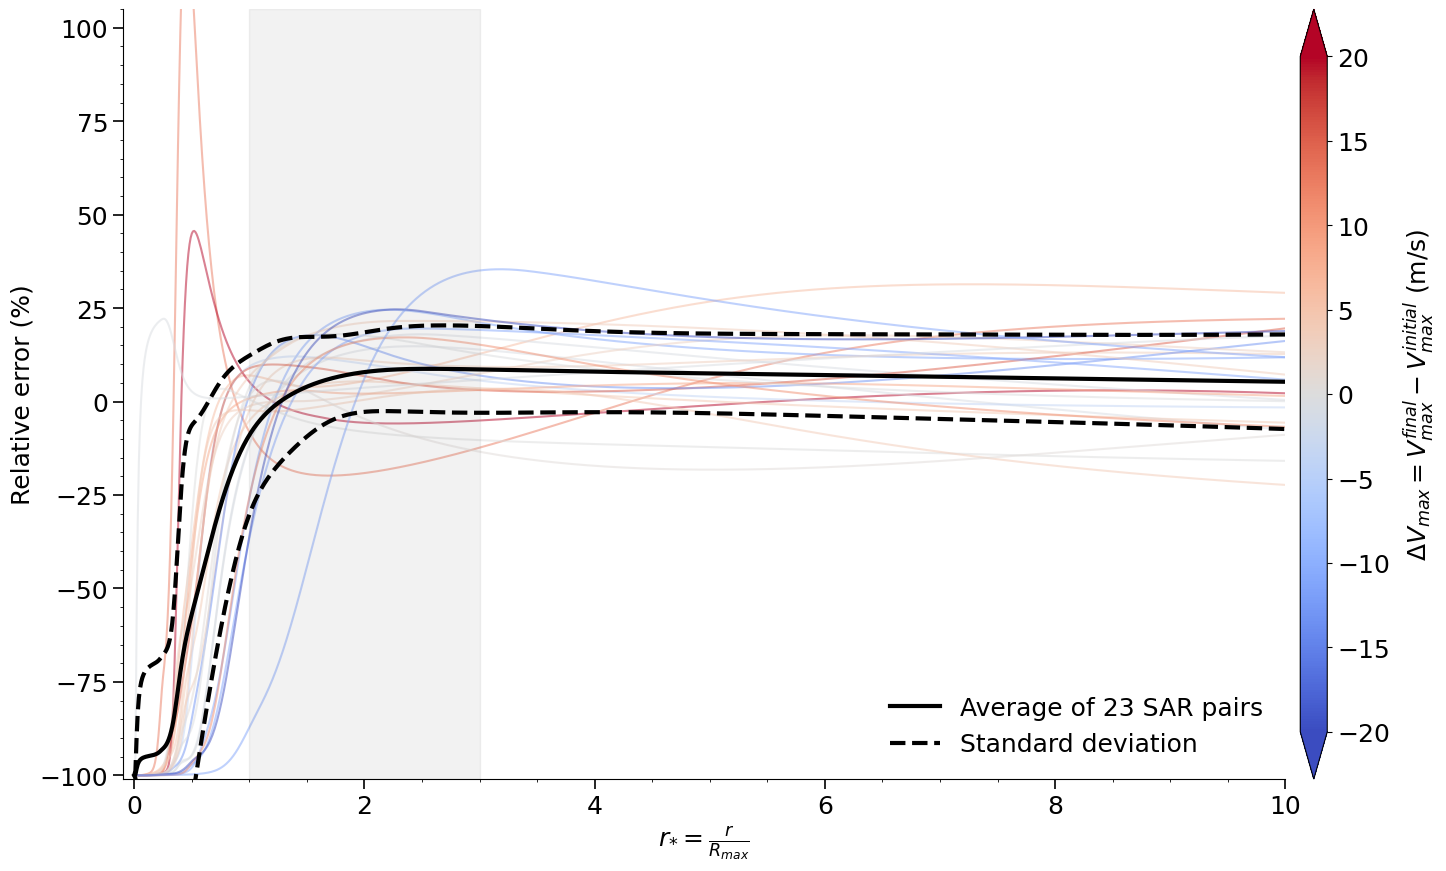

In [133]:
# Colors
c_min = -20
c_max = 20
delta_vmx = d.vmx_fin - d.vmx_ini
d['delta_vmx_color'] = (delta_vmx - c_min) / (c_max - c_min)
cmap  = mpl.cm.get_cmap('coolwarm')

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 + d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 - d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err * 100, c=cmap(d.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
    
# Shaded area
ax.axvspan(1,3, alpha=0.1, color='grey')
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$\Delta V_{max} = V_{max}^{final} - V_{max}^{initial}$ (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')

### 3) Tests with SST

In [134]:
### ADD SST (1)
dsg2 = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg2 = dsg2.where(dsg2.distance_to_coast > dsg2.R17_1D * 1000, drop=True)
dsg2 = dsg2.where(abs(dsg2.lat_center) < 30, drop=True)
dsg2 = dsg2.where(dsg2.B_hol > 0.1, drop=True)
dsg2 = dsg2.where(dsg2.Vmax_1D > 20, drop=True)
print('Nb of storms: {}'.format(len(dsg2.time)))

sst_pth = '/home/arthur/data/sst/dsg_sst_combot.nc'
sst     = xr.open_dataset(sst_pth)

dsg2['prestorm_sst'] = xr.DataArray(
    data=np.array(sst.prestorm_SST),
    dims={'time': dsg2.time}
)
dsg2['rSST'] = xr.DataArray(
    data=np.array(sst.rSST),
    dims={'time': dsg2.time}
)

# Additional filter
dsg2 = dsg2.where(dsg2.Vmax_1D > 30, drop=True)

### ADD SST (2)
dsf['pre_sst'] = dsf.K.copy(deep=True) * np.nan
dsf['rel_sst'] = dsf.K.copy(deep=True) * np.nan
for p in tqdm(range(len(dsf.pair))):
    dsf.pre_sst[p] = dsg2.where(dsg2.storm_id == dsf.isel(pair=p).tc_id, drop=True).isel(time=dsf.isel(pair=p).idx_ini).prestorm_sst
    dsf.rel_sst[p] = dsg2.where(dsg2.storm_id == dsf.isel(pair=p).tc_id, drop=True).isel(time=dsf.isel(pair=p).idx_ini).rSST

Nb of storms: 184


  0%|          | 0/40 [00:00<?, ?it/s]

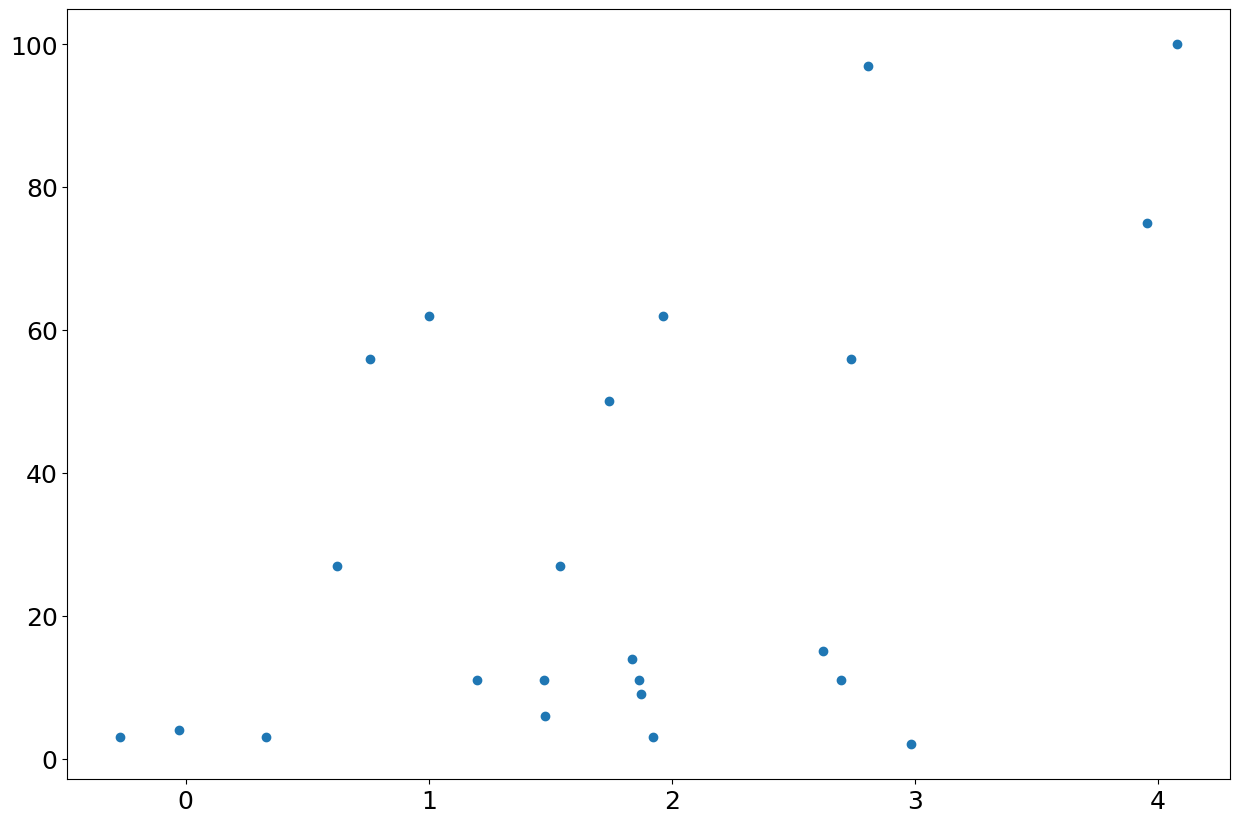

In [135]:
# Tests
# plt.scatter(dsf.pre_sst, dsf.K)
plt.scatter(dsf.where(keep, drop=True).rel_sst, dsf.where(keep, drop=True).K) # doesn't change anything

### Debugging

delta_h = 23.9 hrs
Binary search started...
Binary search ended. K = 2


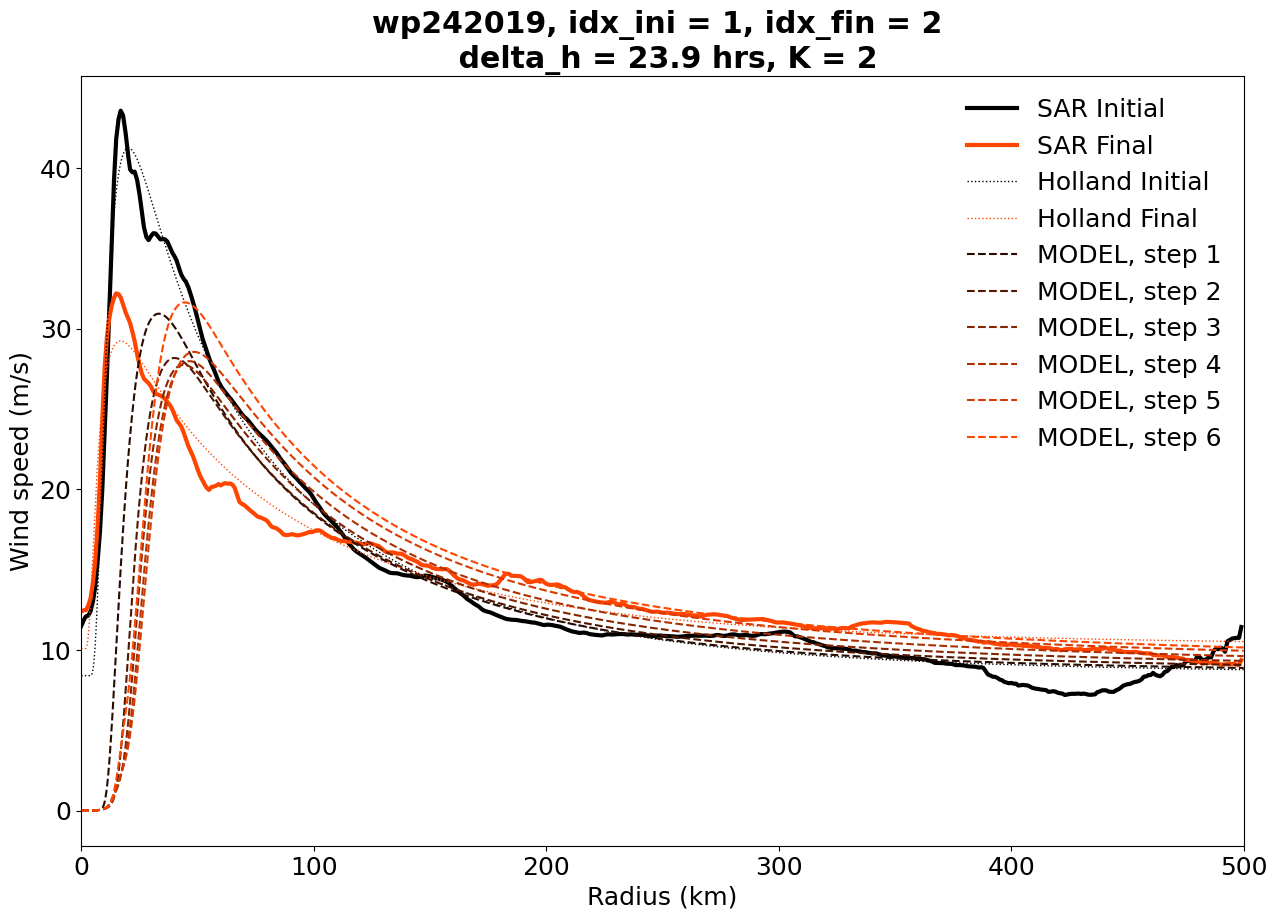

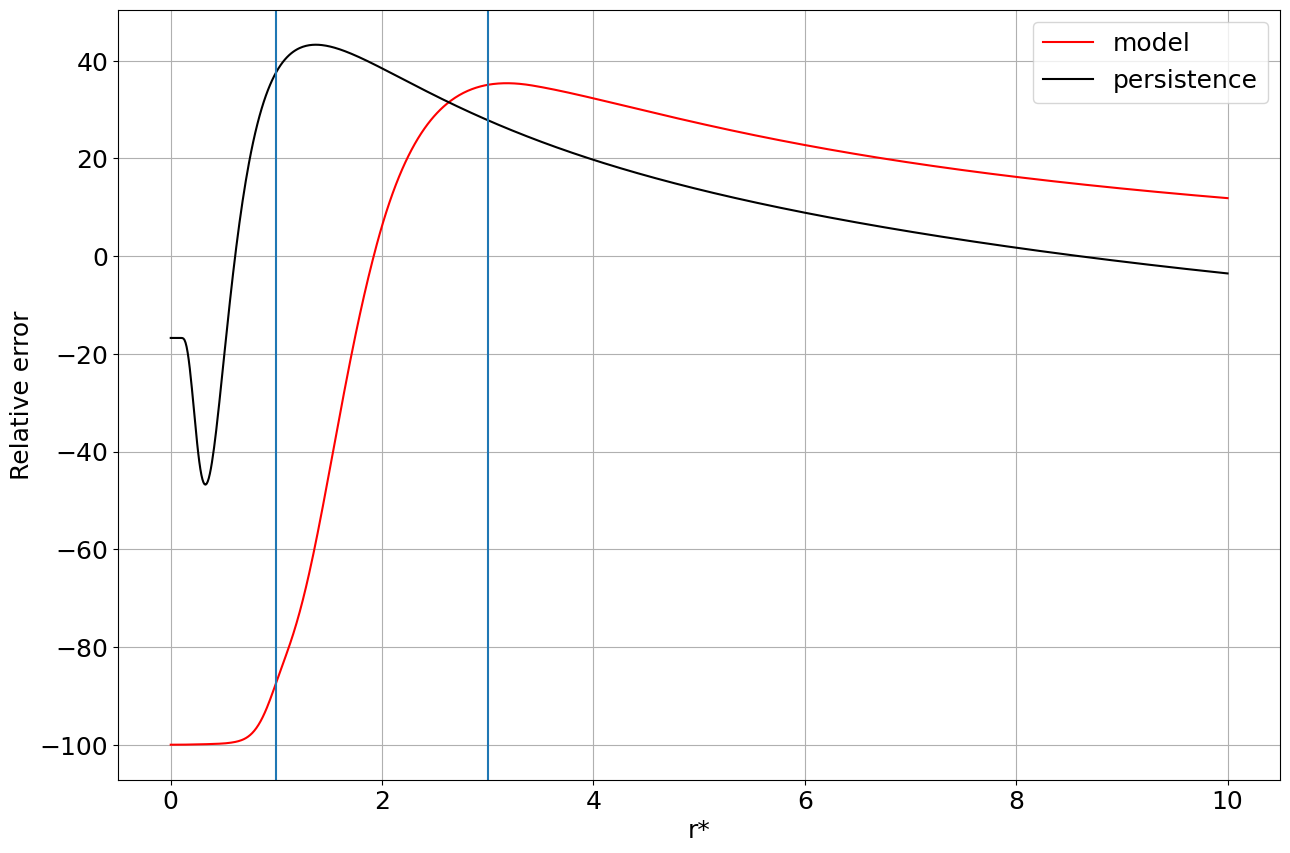

In [136]:
### Choose case
tc_id   = 'wp242019'
idx_ini = 1
idx_fin = 2

# Script
dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
ds_ini     = dsi.isel(time=idx_ini)
ds_fin     = dsi.isel(time=idx_fin)   
V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
print('delta_h = {:.1f} hrs'.format(delta_h))
# Compute VK10 if delta_h is less than threshold
if delta_h <= time_thresh:
    try:
        print('Binary search started...')
        vk10s, Kfit = binary_search(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), np.nanmax(V_fin), float(abs(coriolis(ds_fin.lat_center))), delta_h, K_low=0, K_hgh=100)
        print('Binary search ended. K = {}'.format(Kfit))
        # Compute RMSE
        rmse        = np.sqrt(np.nanmean((vk10s[-1] - Vh_fin) ** 2))
        rmse_prs    = np.sqrt(np.nanmean((Vh_ini - Vh_fin) ** 2))    # Persistence
        # print('Dt = {:.1f}h, Vmax = {:.1f} m/s, Kfit = {}'.format(delta_h, np.nanmax(Vh_ini), Kfit))

        ### Compute relative errors and put that on an r_star-grid
        # Option 1: Compute relative to Holland final profile
        rel_err          = (vk10s[-1] - Vh_fin) / Vh_fin
        rmx              = rs[np.nanargmax(Vh_fin)]
        r_star           = rs / rmx
        rel_err_star     = np.interp(r_ref, r_star, rel_err)
        rel_err_prs      = (Vh_ini - Vh_fin) / Vh_fin                # Persistence
        rel_err_prs_star = np.interp(r_ref, r_star, rel_err_prs)     # Persistence
        # # Option 2: Compute relative to SAR final profile
        # rel_err          = (vk10s[-1] - V_fin) / V_fin
        # rmx              = rs[np.nanargmax(V_fin)]
        # r_star           = rs / rmx
        # rel_err_star     = np.interp(r_ref, r_star, rel_err)
        # rel_err_prs      = (Vh_ini - V_fin) / V_fin                  # Persistence
        # rel_err_prs_star = np.interp(r_ref, r_star, rel_err_prs)     # Persistence

        # Appends
        IDXS_INI.append(idx_ini), IDXS_FIN.append(idx_fin), TC_IDS.append(tc_id), DELTA_HS.append(delta_h), KS.append(Kfit), RMSES.append(rmse)
        RMSES_PRS.append(rmse_prs), VMXS_INI.append(np.nanmax(V_ini)), VMXS_FIN.append(np.nanmax(V_fin))
        REL_ERRS.append(rel_err_star), REL_ERRS_PRS.append(rel_err_prs_star)

        # Plot
        plt.title('{}, idx_ini = {}, idx_fin = {} \n delta_h = {:.1f} hrs, K = {}'.format(tc_id, idx_ini, idx_fin, delta_h, Kfit), weight='bold')
        # SAR profiles
        plt.plot(rs / 1000, V_ini,  c='k',         linewidth=3,                     label='SAR Initial')
        plt.plot(rs / 1000, V_fin,  c='orangered', linewidth=3,                     label='SAR Final')
        # Holland profiles
        plt.plot(rs / 1000, Vh_ini, c='k',         linewidth=1, linestyle='dotted', label='Holland Initial')
        plt.plot(rs / 1000, Vh_fin, c='orangered', linewidth=1, linestyle='dotted', label='Holland Final')
        # Model
        l    = len(vk10s)
        clrs = cm(np.linspace(0, 1, l))
        for k in range(1, l):
            plt.plot(rs / 1000, vk10s[k], linestyle='dashed', c=clrs[k], label='MODEL, step {}'.format(k))
        # Legend
        plt.xlabel('Radius (km)');plt.ylabel('Wind speed (m/s)')
        plt.xlim(0, 500);plt.legend(frameon=False)
        plt.savefig(PTHS['sav_dir'] + 'cases/{}_ini{}_fin{}'.format(tc_id, idx_ini, idx_fin));plt.show()
        
        # Plot error
        plt.plot(r_ref, rel_err_star * 100,     label='model', c='r')
        plt.plot(r_ref, rel_err_prs_star * 100, label='persistence', c='k')
        plt.axvline(1);plt.axvline(3)
        plt.xlabel('r*');plt.ylabel('Relative error')
        plt.legend();plt.grid()

    # except InertiallyUnstableError:
    #     print('Inertially unstable wind profile in function N()')
    except KfitError:
        print('K fitting procedure led to K = 0')